In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

df = pd.read_parquet('../data/rucphen_precipitation_clean.parquet')
df

,timestamp,precipitation,percentage
0,2019-01-01 00:00:00,0.000000,7.895
1,2019-01-01 00:05:00,0.000000,7.895
2,2019-01-01 00:10:00,0.000000,7.895
3,2019-01-01 00:15:00,0.000000,7.895
4,2019-01-01 00:20:00,0.000000,7.895
...,...,...,...
498217,2023-10-12 23:35:00,0.010010,2.632
498218,2023-10-12 23:40:00,0.039978,2.632
498219,2023-10-12 23:45:00,0.049988,2.632
498220,2023-10-12 23:50:00,0.039978,2.632


In [2]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


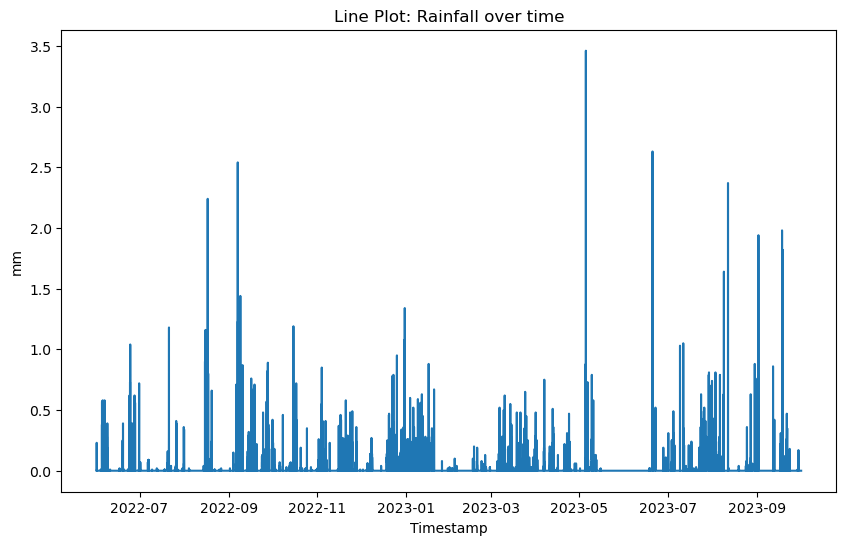

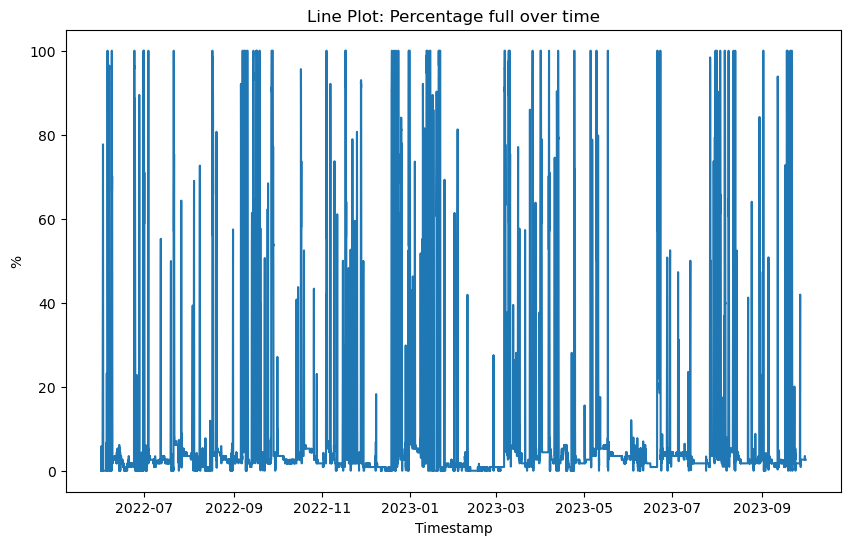

In [3]:
show_df(df, pd.to_datetime('2022-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

C:\Users\Optic\AppData\Local\Temp\ipykernel_51020\2379162479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


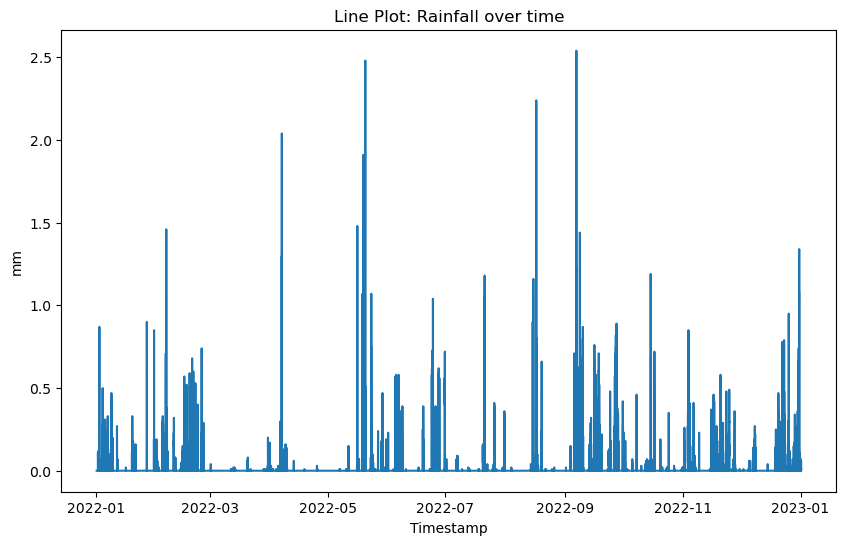

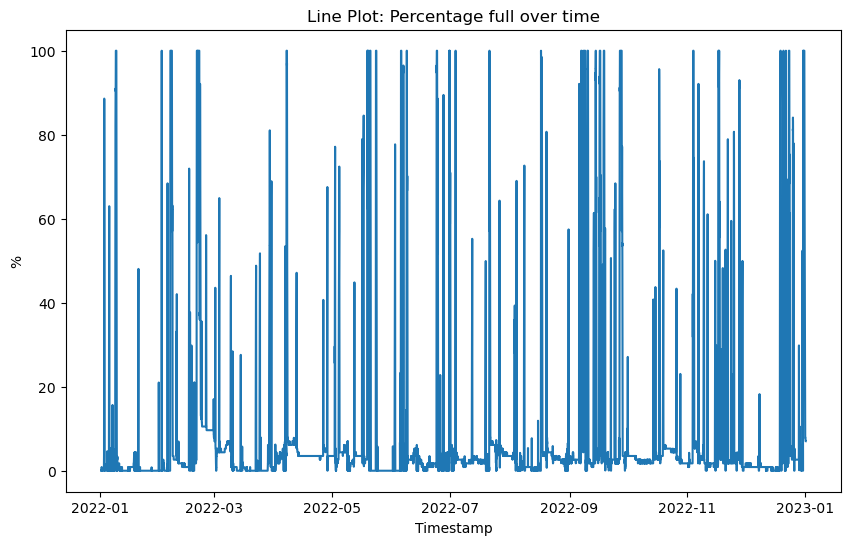

In [4]:
start_timestamp = pd.to_datetime('2022-01-01 08:00:00')
end_timestamp = pd.to_datetime('2023-01-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df = df[mask]
df.fillna(0, inplace=True)
show_df(df)

In [5]:
# Datetime featurs
# Extracting features
df_features = df.copy()
df_features['hour'] = df_features['timestamp'].dt.hour
df_features['dayofweek'] = df_features['timestamp'].dt.dayofweek
df_features['isweekend'] = df_features['timestamp'].dt.weekday >= 5  # True if it's Saturday or Sunday, False otherwise
df_features['month'] = df_features['timestamp'].dt.month

df_features['isweekend'] = df_features['isweekend'].astype(int)
df_features.drop('timestamp', axis=1, inplace=True)

# Lags
# Sort the DataFrame by timestamp
# df = df.sort_values(by='timestamp')

# Define the lags you want
lags = [1, 2, 3, 6]

# Add lag features for 'precipitation'
for lag in lags:
    df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

# Add lag features for 'percentage'
for lag in lags:
    df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

# Drop rows with NaN values introduced by the lag operation
df_features = df_features.dropna()

# Reset index if needed
df_features = df_features.reset_index(drop=True)


df_features.head()

,precipitation,percentage,hour,dayofweek,isweekend,month,precipitation_lag_1,precipitation_lag_2,precipitation_lag_3,precipitation_lag_6,percentage_lag_1,percentage_lag_2,percentage_lag_3,percentage_lag_6
0,0.0,0.0,8,5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,8,5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,8,5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,8,5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,8,5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Extract features and target from the DataFrame
X = df_features.loc[:, df_features.columns != 'percentage']
y = df_features['percentage']

# # Convert to PyTorch tensors
# X = torch.tensor(X.values, dtype=torch.float32)
# y = torch.tensor(y.values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Create and configure the TPOT regressor
tpot_regressor = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42)

# Fit the TPOT regressor to the training data
tpot_regressor.fit(X_train, y_train)

# Score the accuracy on the test set
print(tpot_regressor.score(X_test, y_test))

# Export the best pipeline as a Python script
tpot_regressor.export('tpot_boston_pipeline.py')


In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.8417169166682704
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDRegressor(alpha=0.001, eta0=0.01, fit_intercept=True, l1_ratio=0.5, learning_rate="constant", loss="epsilon_insensitive", penalty="elasticnet", power_t=100.0)),
    RandomForestRegressor(bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=4, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

c:\Users\Optic\anaconda3\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


In [10]:

mse = mean_squared_error(y_test, results)

print(f"Mean Squared Error (MSE): {mse:.2f}")


Mean Squared Error (MSE): 1.63


In [12]:
for i in range(0, len(results)):
    print(f"Predicted: {results[i]:.2f}, Actual: {y_test.iloc[i]:.2f}")

Predicted: 5.27, Actual: 5.26
Predicted: 5.25, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.27, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted: 5.26, Actual: 5.26
Predicted:

In [13]:
#exports weights
import pickle

with open('weights.pkl', 'wb') as f:
    pickle.dump(exported_pipeline, f)
    

In [15]:
#visualize feature importances 
importances = exported_pipeline.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in exported_pipeline.steps[1][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f+1}. {X_train.columns[indices[f]]} ({importances[indices[f]]})")
    

Feature ranking:
1. percentage_lag_2 (0.8278933440634821)
2. precipitation (0.14334588889911426)
3. percentage_lag_3 (0.02759475753736957)


IndexError: index 13 is out of bounds for axis 0 with size 13

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.10462254361904769
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    Nystroem(gamma=0.45, kernel="laplacian", n_components=9),
    AdaBoostRegressor(learning_rate=0.1, loss="exponential", n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


In [17]:
mse = mean_squared_error(y_test, results)

print(f"Mean Squared Error (MSE): {mse:.2f}")


Mean Squared Error (MSE): 636.95
